Let us try applying data augmentation this time. 

Because the dataset becomes large, we would have to use a data generator for training. 

In [22]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
import tensorflow_addons as tfa
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow_probability import distributions as tfd
import seaborn as sns
from keras.utils.np_utils import to_categorical
import os
from glob import glob

# Load Data

In [8]:
## season 2 dataframes 
train_x_2 = pd.read_csv('train_x_df.csv')
train_y_2 = pd.read_csv('train_y_df.csv') 
test_x_2 = pd.read_csv('test_x_df.csv') 
submission = pd.read_csv('sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape


((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [10]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

x_train.shape, y_train.shape, x_test.shape

((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [126]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [127]:
def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [11]:
full_df = np.concatenate([x_train, y_train], axis = 1) 
full_df.shape


(7661, 1500, 10)

In [12]:
OHLC = full_df[:,:,[1,2,3,4]] 
OHLC.shape


(7661, 1500, 4)

In [13]:
volume_features = full_df[:,:,[5,6,7,8,9]]
volume_features.shape

(7661, 1500, 5)

# Preprocess Data

This time we augment data by adding random gaussian noise. 

In [38]:
K = 120 
N = 30
seq_len = 1500 
features_price = 4 
features_volume = 5 
val_split = 0.1 

In [42]:
val_idx = random.sample(range(0, OHLC.shape[0]), int(OHLC.shape[0] * val_split)) 

In [43]:
print("get train data")
train_OHLC = OHLC[[i for i in range(OHLC.shape[0]) if i not in val_idx],:,:] 
train_volume = volume_features[[i for i in range(OHLC.shape[0]) if i not in val_idx],:,:] 
print("get val data") 
val_OHLC = OHLC[val_idx, :,:] 
val_volume = volume_features[val_idx,:,:] 

train_OHLC.shape, train_volume.shape, val_OHLC.shape, val_volume.shape 

get train data
get val data


((6895, 1500, 4), (6895, 1500, 5), (766, 1500, 4), (766, 1500, 5))

In [63]:
# augment train data by adding noise  
train_OHLC_aug = [] 
train_volume_aug = [] 
min_price = 0
min_vol = 0 
for i in tqdm(range(train_OHLC.shape[0])): 
    noised_price = train_OHLC[i,:,:] + np.random.normal(0,random.uniform(0.00001,0.0001), (seq_len, features_price)) 
    # adjust buy price to be 1 
    buy_price = noised_price[1379,0]
    if buy_price > 1.0:  
        diff = buy_price - 1.0 
        noised_price -= diff  
    elif buy_price < 1.0:  
        diff = 1.0 - buy_price
        noised_price += diff
        
    noised_volume = train_volume[i,:,:] + np.random.normal(0,random.uniform(0.00001,0.0001), (seq_len, features_volume))
    
    # make sure that both price and volumes are non-negative
    noised_price[noised_price < 0] = 0 
    noised_volume[noised_volume < 0] = 0
    
    train_OHLC_aug.append(noised_price) 
    train_volume_aug.append(noised_volume) 
    
    
train_OHLC_aug = np.asarray(train_OHLC_aug) 
train_volume_aug = np.asarray(train_volume_aug) 

train_OHLC_aug.shape, train_volume_aug.shape
    

100%|██████████| 6895/6895 [00:04<00:00, 1682.65it/s]


((6895, 1500, 4), (6895, 1500, 5))

In [66]:
train_price = np.concatenate([train_OHLC, train_OHLC_aug], axis = 0) 
train_vol = np.concatenate([train_volume, train_volume_aug], axis = 0) 

train_price.shape, train_vol.shape

((13790, 1500, 4), (13790, 1500, 5))

In [102]:
X_price = np.zeros((train_price.shape[0]*(seq_len-N-K),N,features_price), dtype=np.float32) 
X_volume = np.zeros((train_vol.shape[0]*(seq_len-N-K),N,features_volume), dtype=np.float32) 
Y = np.zeros((train_price.shape[0]*(seq_len-N-K),), dtype=np.float32) 

X_price_val = np.zeros((val_OHLC.shape[0]*(seq_len-N-K),N,features_price), dtype=np.float32) 
X_volume_val = np.zeros((val_volume.shape[0]*(seq_len-N-K),N,features_volume), dtype=np.float32)
Y_val = np.zeros((val_volume.shape[0]*(seq_len-N-K),), dtype=np.float32)

print(X_price.shape, X_volume.shape, Y.shape) 
print(X_price_val.shape, X_volume_val.shape, Y_val.shape)

(18616500, 30, 4) (18616500, 30, 5) (18616500,)
(1034100, 30, 4) (1034100, 30, 5) (1034100,)


In [103]:
# get train data  
cnt = 0 
for j in tqdm(range(train_price.shape[0]), position = 0, leave = True): 
    i = 0
    while i+N+K < 1500: 
        X_price[cnt,:,:] = train_price[j, i:i+N, :] 
        X_volume[cnt,:,:] = train_vol[j, i:i+N, :] 
        Y[cnt] = train_price[j,i+N+K,0] # get open prices as target
        i += 1  
        cnt += 1 

100%|██████████| 13790/13790 [01:03<00:00, 215.70it/s]


In [110]:
# get validation data 
cnt = 0 
for j in tqdm(range(val_OHLC.shape[0]), position = 0, leave = True): 
    i = 0 
    while i+N+K < 1500: 
        X_price_val[cnt,:,:] = val_OHLC[j, i:i+N, :] 
        X_volume_val[cnt,:,:] = val_volume[j, i:i+N, :] 
        Y_val[cnt] = val_OHLC[j, i+N+K, 0]  
        i += 1 
        cnt += 1 
        

100%|██████████| 766/766 [00:04<00:00, 184.15it/s]


# Define Model and train

In [113]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='glorot_uniform',
                                              trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='glorot_uniform',
                                           trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='glorot_uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='glorot_uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


In [114]:
def transformer_block(inputs, node, drop_rate, activation): 
    attn_output = MultiHeadAttention(num_heads = 4, key_dim = node)(inputs, inputs) 
    attn_output = Dropout(drop_rate)(attn_output) 
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output) 
    ffn_output = Dense(node, activation = activation)(out1) 
    ffn_output = Dense(node)(ffn_output) 
    ffn_output = Dropout(drop_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output) 
    return out2
    
    

def build_transformer(node = 64, activation = 'relu', drop_rate = 0.2, num_layers = 3): 
    time_embedding_price = Time2Vector(N)
    time_embedding_volume = Time2Vector(N)
    ## price transformer 
    price_inputs = Input((N, features_price))  
    bn = BatchNormalization()(price_inputs) 
    x = time_embedding_price(bn) 
    x = Concatenate()([bn, x]) 
    x = Conv1D(node*2, 5, activation = activation)(x) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    x = Conv1D(node, 5, activation = activation)(x) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    positions = tf.range(start=0, limit=x.shape[1], delta=1)
    positions = Embedding(input_dim = x.shape[1], output_dim = node)(positions) 
    x = x + positions 
    for i in range(num_layers): 
        x = transformer_block(x, node, drop_rate, activation)
    x = GlobalMaxPooling1D()(x) 
    
    ## volume transformer 
    volume_inputs = Input((N, features_volume)) 
    bn_v = BatchNormalization()(volume_inputs) 
    x_v = time_embedding_volume(bn_v) 
    x_v = Concatenate()([bn_v, x_v]) 
    x_v = Conv1D(node*2, 5, activation = activation)(x_v) 
    x_v = MaxPooling1D(3)(x_v) 
    x_v = Dropout(drop_rate)(x_v)
    x_v = Conv1D(node, 5, activation = activation)(x_v) 
    x_v = MaxPooling1D(3)(x_v) 
    x_v = Dropout(drop_rate)(x_v)
    positions_v = tf.range(start=0, limit=x_v.shape[1], delta=1) 
    positions_v = Embedding(input_dim=x_v.shape[1], output_dim = node)(positions_v) 
    x_v = x_v + positions_v 
    for i in range(num_layers):  
        x_v = transformer_block(x_v, node, drop_rate, activation)  
    x_v = GlobalMaxPooling1D()(x_v) 
    
    merge = Concatenate()([x, x_v]) 
    blend = Dense(64, activation = 'relu')(merge) 
    blend = BatchNormalization()(blend) 
    outputs = Dense(1, activation = 'relu')(blend) 
    model = Model(inputs=[price_inputs, volume_inputs],outputs=outputs) 
    model.compile(loss = 'mape', optimizer = 'adam', metrics=['mae','mse','mape']) 
    return model


In [115]:
model = build_transformer()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30, 4)        16          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 30, 5)        20          input_2[0][0]                    
______________________________________________________________________________________________

In [116]:
model_path = 'transformer_augmented_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit([X_price, X_volume], 
                     Y, 
                     batch_size = 128, 
                     epochs = 50, 
                     callbacks = [learning_rate_reduction, checkpoint], 
                     validation_data = ([X_price_val, X_volume_val], Y_val))


Epoch 1/50
145442/145442 [==============================] - 3000s 20ms/step - loss: 1.7805 - mae: 0.0178 - mse: 0.0032 - mape: 1.7805 - val_loss: 0.9809 - val_mae: 0.0098 - val_mse: 2.4740e-04 - val_mape: 0.9809

Epoch 00001: val_loss improved from inf to 0.98094, saving model to transformer_augmented_epoch_001_val_0.981.h5
Epoch 2/50
145442/145442 [==============================] - 2922s 20ms/step - loss: 1.1065 - mae: 0.0111 - mse: 3.2048e-04 - mape: 1.1065 - val_loss: 1.0506 - val_mae: 0.0106 - val_mse: 2.7096e-04 - val_mape: 1.0506

Epoch 00002: val_loss did not improve from 0.98094
Epoch 3/50
145442/145442 [==============================] - 2953s 20ms/step - loss: 1.0828 - mae: 0.0108 - mse: 3.1120e-04 - mape: 1.0828 - val_loss: 1.0080 - val_mae: 0.0101 - val_mse: 2.6116e-04 - val_mape: 1.0080

Epoch 00003: val_loss did not improve from 0.98094
Epoch 4/50
 14939/145442 [==>...........................] - ETA: 42:18 - loss: 1.0711 - mae: 0.0107 - mse: 3.0658e-04 - mape: 1.0711

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 33134/145442 [=====>........................] - ETA: 36:29 - loss: 1.0703 - mae: 0.0107 - mse: 3.0657e-04 - mape: 1.0703

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 53687/145442 [==========>...................] - ETA: 30:09 - loss: 1.0698 - mae: 0.0107 - mse: 3.0627e-04 - mape: 1.0698

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 73718/145442 [==============>...............] - ETA: 23:29 - loss: 1.0693 - mae: 0.0107 - mse: 3.0582e-04 - mape: 1.0693

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 93899/145442 [==================>...........] - ETA: 16:51 - loss: 1.0688 - mae: 0.0107 - mse: 3.0547e-04 - mape: 1.0688

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



112045/145442 [======================>.......] - ETA: 10:53 - loss: 1.0684 - mae: 0.0107 - mse: 3.0532e-04 - mape: 1.0684

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



132546/145442 [==========================>...] - ETA: 4:12 - loss: 1.0680 - mae: 0.0107 - mse: 3.0525e-04 - mape: 1.0680

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



145442/145442 [==============================] - 2918s 20ms/step - loss: 1.0677 - mae: 0.0107 - mse: 3.0523e-04 - mape: 1.0677 - val_loss: 1.0249 - val_mae: 0.0103 - val_mse: 2.8114e-04 - val_mape: 1.0249

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00004: val_loss did not improve from 0.98094
Epoch 5/50
  7260/145442 [>.............................] - ETA: 46:55 - loss: 1.0488 - mae: 0.0105 - mse: 2.9640e-04 - mape: 1.0488

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 27504/145442 [====>.........................] - ETA: 40:00 - loss: 1.0458 - mae: 0.0105 - mse: 2.9653e-04 - mape: 1.0458

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 47684/145442 [========>.....................] - ETA: 32:40 - loss: 1.0453 - mae: 0.0105 - mse: 2.9628e-04 - mape: 1.0453

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 67483/145442 [============>.................] - ETA: 25:48 - loss: 1.0451 - mae: 0.0105 - mse: 2.9593e-04 - mape: 1.0451

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 79006/145442 [===============>..............] - ETA: 21:51 - loss: 1.0450 - mae: 0.0105 - mse: 2.9577e-04 - mape: 1.0450

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 87548/145442 [=================>............] - ETA: 19:01 - loss: 1.0450 - mae: 0.0105 - mse: 2.9570e-04 - mape: 1.0450

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 99181/145442 [===================>..........] - ETA: 15:10 - loss: 1.0449 - mae: 0.0105 - mse: 2.9558e-04 - mape: 1.0449

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



107769/145442 [=====================>........] - ETA: 12:20 - loss: 1.0449 - mae: 0.0105 - mse: 2.9550e-04 - mape: 1.0449

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



119415/145442 [=======================>......] - ETA: 8:31 - loss: 1.0448 - mae: 0.0105 - mse: 2.9542e-04 - mape: 1.0448

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



127798/145442 [=========================>....] - ETA: 5:46 - loss: 1.0447 - mae: 0.0105 - mse: 2.9537e-04 - mape: 1.0447

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



139444/145442 [===========================>..] - ETA: 1:57 - loss: 1.0446 - mae: 0.0105 - mse: 2.9531e-04 - mape: 1.0446

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



145442/145442 [==============================] - 2911s 20ms/step - loss: 1.0446 - mae: 0.0105 - mse: 2.9528e-04 - mape: 1.0446 - val_loss: 0.9538 - val_mae: 0.0095 - val_mse: 2.4749e-04 - val_mape: 0.9538

Epoch 00005: val_loss improved from 0.98094 to 0.95381, saving model to transformer_augmented_epoch_005_val_0.954.h5
Epoch 6/50
  2516/145442 [..............................] - ETA: 45:31 - loss: 1.0411 - mae: 0.0104 - mse: 2.9613e-04 - mape: 1.0411

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 14395/145442 [=>............................] - ETA: 42:13 - loss: 1.0400 - mae: 0.0104 - mse: 2.9500e-04 - mape: 1.0400

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 22840/145442 [===>..........................] - ETA: 39:25 - loss: 1.0397 - mae: 0.0104 - mse: 2.9486e-04 - mape: 1.0397

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 34460/145442 [======>.......................] - ETA: 35:46 - loss: 1.0396 - mae: 0.0104 - mse: 2.9512e-04 - mape: 1.0396

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 42722/145442 [=======>......................] - ETA: 33:07 - loss: 1.0397 - mae: 0.0104 - mse: 2.9532e-04 - mape: 1.0397

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 54483/145442 [==========>...................] - ETA: 29:20 - loss: 1.0397 - mae: 0.0104 - mse: 2.9541e-04 - mape: 1.0397

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 59480/145442 [===========>..................] - ETA: 27:42 - loss: 1.0396 - mae: 0.0104 - mse: 2.9542e-04 - mape: 1.0396

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 74564/145442 [==============>...............] - ETA: 22:52 - loss: 1.0396 - mae: 0.0104 - mse: 2.9532e-04 - mape: 1.0396

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 79477/145442 [===============>..............] - ETA: 21:15 - loss: 1.0396 - mae: 0.0104 - mse: 2.9527e-04 - mape: 1.0396

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 94478/145442 [==================>...........] - ETA: 16:25 - loss: 1.0395 - mae: 0.0104 - mse: 2.9510e-04 - mape: 1.0395

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 99443/145442 [===================>..........] - ETA: 14:48 - loss: 1.0394 - mae: 0.0104 - mse: 2.9502e-04 - mape: 1.0394

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



114556/145442 [======================>.......] - ETA: 9:56 - loss: 1.0393 - mae: 0.0104 - mse: 2.9481e-04 - mape: 1.0393

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



119897/145442 [=======================>......] - ETA: 8:12 - loss: 1.0393 - mae: 0.0104 - mse: 2.9475e-04 - mape: 1.0393

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



135122/145442 [==========================>...] - ETA: 3:19 - loss: 1.0392 - mae: 0.0104 - mse: 2.9461e-04 - mape: 1.0392

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



140431/145442 [===========================>..] - ETA: 1:36 - loss: 1.0391 - mae: 0.0104 - mse: 2.9457e-04 - mape: 1.0391

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 10049/145442 [=>............................] - ETA: 44:07 - loss: 1.0358 - mae: 0.0104 - mse: 2.9601e-04 - mape: 1.0358

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 15421/145442 [==>...........................] - ETA: 42:22 - loss: 1.0357 - mae: 0.0104 - mse: 2.9504e-04 - mape: 1.0357

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 30642/145442 [=====>........................] - ETA: 37:13 - loss: 1.0353 - mae: 0.0104 - mse: 2.9360e-04 - mape: 1.0353

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 36244/145442 [======>.......................] - ETA: 35:25 - loss: 1.0353 - mae: 0.0104 - mse: 2.9331e-04 - mape: 1.0353

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 51425/145442 [=========>....................] - ETA: 30:31 - loss: 1.0356 - mae: 0.0104 - mse: 2.9301e-04 - mape: 1.0356

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 56824/145442 [==========>...................] - ETA: 28:49 - loss: 1.0356 - mae: 0.0104 - mse: 2.9297e-04 - mape: 1.0356

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 74407/145442 [==============>...............] - ETA: 23:06 - loss: 1.0357 - mae: 0.0104 - mse: 2.9276e-04 - mape: 1.0357

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 86377/145442 [================>.............] - ETA: 19:13 - loss: 1.0357 - mae: 0.0104 - mse: 2.9264e-04 - mape: 1.0357

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 95302/145442 [==================>...........] - ETA: 16:19 - loss: 1.0357 - mae: 0.0104 - mse: 2.9257e-04 - mape: 1.0357

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



107358/145442 [=====================>........] - ETA: 12:24 - loss: 1.0357 - mae: 0.0104 - mse: 2.9246e-04 - mape: 1.0357

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



115997/145442 [======================>.......] - ETA: 9:36 - loss: 1.0357 - mae: 0.0104 - mse: 2.9238e-04 - mape: 1.0357

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



127841/145442 [=========================>....] - ETA: 5:44 - loss: 1.0357 - mae: 0.0104 - mse: 2.9228e-04 - mape: 1.0357

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



136479/145442 [===========================>..] - ETA: 2:55 - loss: 1.0357 - mae: 0.0104 - mse: 2.9221e-04 - mape: 1.0357

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



145442/145442 [==============================] - 2905s 20ms/step - loss: 1.0357 - mae: 0.0104 - mse: 2.9215e-04 - mape: 1.0357 - val_loss: 0.9781 - val_mae: 0.0098 - val_mse: 2.5793e-04 - val_mape: 0.9781

Epoch 00007: val_loss did not improve from 0.95381
Epoch 8/50
  2839/145442 [..............................] - ETA: 46:24 - loss: 1.0371 - mae: 0.0104 - mse: 2.8784e-04 - mape: 1.0371

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 11568/145442 [=>............................] - ETA: 43:51 - loss: 1.0365 - mae: 0.0104 - mse: 2.8907e-04 - mape: 1.0365

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 23290/145442 [===>..........................] - ETA: 40:01 - loss: 1.0364 - mae: 0.0104 - mse: 2.9011e-04 - mape: 1.0364

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 32241/145442 [=====>........................] - ETA: 36:57 - loss: 1.0362 - mae: 0.0104 - mse: 2.9000e-04 - mape: 1.0362

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 43906/145442 [========>.....................] - ETA: 33:10 - loss: 1.0359 - mae: 0.0104 - mse: 2.8998e-04 - mape: 1.0359

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 52708/145442 [=========>....................] - ETA: 30:11 - loss: 1.0359 - mae: 0.0104 - mse: 2.8991e-04 - mape: 1.0359

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 64367/145442 [============>.................] - ETA: 26:20 - loss: 1.0358 - mae: 0.0104 - mse: 2.8983e-04 - mape: 1.0358

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 73206/145442 [==============>...............] - ETA: 23:26 - loss: 1.0357 - mae: 0.0104 - mse: 2.8977e-04 - mape: 1.0357

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 85084/145442 [================>.............] - ETA: 19:35 - loss: 1.0356 - mae: 0.0104 - mse: 2.8974e-04 - mape: 1.0356

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 93873/145442 [==================>...........] - ETA: 16:44 - loss: 1.0355 - mae: 0.0104 - mse: 2.8974e-04 - mape: 1.0355

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



105740/145442 [====================>.........] - ETA: 12:54 - loss: 1.0355 - mae: 0.0104 - mse: 2.8979e-04 - mape: 1.0355

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



114465/145442 [======================>.......] - ETA: 10:03 - loss: 1.0355 - mae: 0.0104 - mse: 2.8982e-04 - mape: 1.0355

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



126347/145442 [=========================>....] - ETA: 6:12 - loss: 1.0354 - mae: 0.0104 - mse: 2.8987e-04 - mape: 1.0354

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



135198/145442 [==========================>...] - ETA: 3:19 - loss: 1.0354 - mae: 0.0104 - mse: 2.8991e-04 - mape: 1.0354

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



143386/145442 [============================>.] - ETA: 40s - loss: 1.0354 - mae: 0.0104 - mse: 2.8993e-04 - mape: 1.0354

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  5887/145442 [>.............................] - ETA: 45:28 - loss: 1.0270 - mae: 0.0103 - mse: 2.8980e-04 - mape: 1.0270

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 18524/145442 [==>...........................] - ETA: 41:20 - loss: 1.0274 - mae: 0.0103 - mse: 2.8918e-04 - mape: 1.0274

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 26574/145442 [====>.........................] - ETA: 38:36 - loss: 1.0276 - mae: 0.0103 - mse: 2.8897e-04 - mape: 1.0276

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 39371/145442 [=======>......................] - ETA: 34:18 - loss: 1.0277 - mae: 0.0103 - mse: 2.8858e-04 - mape: 1.0277

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 47471/145442 [========>.....................] - ETA: 31:43 - loss: 1.0278 - mae: 0.0103 - mse: 2.8835e-04 - mape: 1.0278

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 60273/145442 [===========>..................] - ETA: 27:31 - loss: 1.0278 - mae: 0.0103 - mse: 2.8805e-04 - mape: 1.0278

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 68463/145442 [=============>................] - ETA: 24:52 - loss: 1.0278 - mae: 0.0103 - mse: 2.8784e-04 - mape: 1.0278

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 81231/145442 [===============>..............] - ETA: 20:45 - loss: 1.0278 - mae: 0.0103 - mse: 2.8760e-04 - mape: 1.0278

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 89413/145442 [=================>............] - ETA: 18:07 - loss: 1.0277 - mae: 0.0103 - mse: 2.8746e-04 - mape: 1.0277

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



139225/145442 [===========================>..] - ETA: 2:00 - loss: 1.0275 - mae: 0.0103 - mse: 2.8678e-04 - mape: 1.0275

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 14255/145442 [=>............................] - ETA: 42:18 - loss: 1.0283 - mae: 0.0103 - mse: 2.8478e-04 - mape: 1.0283

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 34435/145442 [======>.......................] - ETA: 35:40 - loss: 1.0282 - mae: 0.0103 - mse: 2.8436e-04 - mape: 1.0282

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 54794/145442 [==========>...................] - ETA: 29:09 - loss: 1.0278 - mae: 0.0103 - mse: 2.8407e-04 - mape: 1.0278

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 75270/145442 [==============>...............] - ETA: 22:35 - loss: 1.0274 - mae: 0.0103 - mse: 2.8387e-04 - mape: 1.0274

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 94610/145442 [==================>...........] - ETA: 16:22 - loss: 1.0271 - mae: 0.0103 - mse: 2.8376e-04 - mape: 1.0271

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



114547/145442 [======================>.......] - ETA: 9:57 - loss: 1.0270 - mae: 0.0103 - mse: 2.8372e-04 - mape: 1.0270

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



134713/145442 [==========================>...] - ETA: 3:27 - loss: 1.0268 - mae: 0.0103 - mse: 2.8374e-04 - mape: 1.0268

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



145442/145442 [==============================] - 2875s 20ms/step - loss: 1.0268 - mae: 0.0103 - mse: 2.8375e-04 - mape: 1.0268 - val_loss: 1.0664 - val_mae: 0.0106 - val_mse: 2.6903e-04 - val_mape: 1.0664

Epoch 00010: val_loss did not improve from 0.94753
Epoch 11/50
  8398/145442 [>.............................] - ETA: 44:09 - loss: 1.0226 - mae: 0.0102 - mse: 2.8259e-04 - mape: 1.0226

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 43680/145442 [========>.....................] - ETA: 32:48 - loss: 1.0240 - mae: 0.0103 - mse: 2.8524e-04 - mape: 1.0240

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 63756/145442 [============>.................] - ETA: 26:20 - loss: 1.0241 - mae: 0.0103 - mse: 2.8504e-04 - mape: 1.0241

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



116716/145442 [=======================>......] - ETA: 9:17 - loss: 1.0245 - mae: 0.0103 - mse: 2.8470e-04 - mape: 1.0245

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



137318/145442 [===========================>..] - ETA: 2:37 - loss: 1.0245 - mae: 0.0103 - mse: 2.8457e-04 - mape: 1.0245

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 12543/145442 [=>............................] - ETA: 42:45 - loss: 1.0251 - mae: 0.0103 - mse: 2.8435e-04 - mape: 1.0251

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 32851/145442 [=====>........................] - ETA: 36:27 - loss: 1.0250 - mae: 0.0103 - mse: 2.8388e-04 - mape: 1.0250

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 53645/145442 [==========>...................] - ETA: 29:35 - loss: 1.0251 - mae: 0.0103 - mse: 2.8391e-04 - mape: 1.0251

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 73747/145442 [==============>...............] - ETA: 23:08 - loss: 1.0251 - mae: 0.0103 - mse: 2.8390e-04 - mape: 1.0251

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



113039/145442 [======================>.......] - ETA: 10:28 - loss: 1.0250 - mae: 0.0103 - mse: 2.8376e-04 - mape: 1.0250

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



133067/145442 [==========================>...] - ETA: 4:00 - loss: 1.0249 - mae: 0.0103 - mse: 2.8367e-04 - mape: 1.0249

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



145442/145442 [==============================] - 2885s 20ms/step - loss: 1.0249 - mae: 0.0103 - mse: 2.8360e-04 - mape: 1.0249 - val_loss: 0.9596 - val_mae: 0.0096 - val_mse: 2.4904e-04 - val_mape: 0.9596

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00012: val_loss did not improve from 0.94753
Epoch 13/50
  6944/145442 [>.............................] - ETA: 45:11 - loss: 1.0197 - mae: 0.0102 - mse: 2.8319e-04 - mape: 1.0197

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 26921/145442 [====>.........................] - ETA: 38:22 - loss: 1.0194 - mae: 0.0102 - mse: 2.8225e-04 - mape: 1.0194

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 46874/145442 [========>.....................] - ETA: 31:54 - loss: 1.0198 - mae: 0.0102 - mse: 2.8250e-04 - mape: 1.0198

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



145442/145442 [==============================] - 2870s 20ms/step - loss: 1.0202 - mae: 0.0102 - mse: 2.8236e-04 - mape: 1.0202 - val_loss: 0.9616 - val_mae: 0.0096 - val_mse: 2.4639e-04 - val_mape: 0.9616

Epoch 00013: val_loss did not improve from 0.94753
Epoch 14/50
145442/145442 [==============================] - 2883s 20ms/step - loss: 1.0199 - mae: 0.0102 - mse: 2.7962e-04 - mape: 1.0199 - val_loss: 0.9515 - val_mae: 0.0095 - val_mse: 2.4921e-04 - val_mape: 0.9515

Epoch 00014: val_loss did not improve from 0.94753
Epoch 15/50
 17236/145442 [==>...........................] - ETA: 41:22 - loss: 1.0191 - mae: 0.0102 - mse: 2.8309e-04 - mape: 1.0191

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 36812/145442 [======>.......................] - ETA: 34:57 - loss: 1.0189 - mae: 0.0102 - mse: 2.8208e-04 - mape: 1.0189

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 56628/145442 [==========>...................] - ETA: 28:41 - loss: 1.0190 - mae: 0.0102 - mse: 2.8162e-04 - mape: 1.0190

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 76627/145442 [==============>...............] - ETA: 22:09 - loss: 1.0191 - mae: 0.0102 - mse: 2.8124e-04 - mape: 1.0191

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 96114/145442 [==================>...........] - ETA: 15:53 - loss: 1.0191 - mae: 0.0102 - mse: 2.8098e-04 - mape: 1.0191

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



116493/145442 [=======================>......] - ETA: 9:19 - loss: 1.0191 - mae: 0.0102 - mse: 2.8085e-04 - mape: 1.0191

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



136086/145442 [===========================>..] - ETA: 3:01 - loss: 1.0192 - mae: 0.0102 - mse: 2.8080e-04 - mape: 1.0192

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 19785/145442 [===>..........................] - ETA: 40:32 - loss: 1.0178 - mae: 0.0102 - mse: 2.7966e-04 - mape: 1.0178

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 40645/145442 [=======>......................] - ETA: 33:55 - loss: 1.0176 - mae: 0.0102 - mse: 2.7936e-04 - mape: 1.0176

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 61453/145442 [===========>..................] - ETA: 27:12 - loss: 1.0176 - mae: 0.0102 - mse: 2.7921e-04 - mape: 1.0176

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 82866/145442 [================>.............] - ETA: 20:14 - loss: 1.0176 - mae: 0.0102 - mse: 2.7919e-04 - mape: 1.0176

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



115351/145442 [======================>.......] - ETA: 9:43 - loss: 1.0176 - mae: 0.0102 - mse: 2.7912e-04 - mape: 1.0176

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



137438/145442 [===========================>..] - ETA: 2:35 - loss: 1.0176 - mae: 0.0102 - mse: 2.7913e-04 - mape: 1.0176

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 11867/145442 [=>............................] - ETA: 43:04 - loss: 1.0183 - mae: 0.0102 - mse: 2.7989e-04 - mape: 1.0183

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 31722/145442 [=====>........................] - ETA: 36:40 - loss: 1.0176 - mae: 0.0102 - mse: 2.7777e-04 - mape: 1.0176

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 51627/145442 [=========>....................] - ETA: 30:15 - loss: 1.0174 - mae: 0.0102 - mse: 2.7745e-04 - mape: 1.0174

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 75933/145442 [==============>...............] - ETA: 22:25 - loss: 1.0174 - mae: 0.0102 - mse: 2.7755e-04 - mape: 1.0174

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 98939/145442 [===================>..........] - ETA: 15:00 - loss: 1.0174 - mae: 0.0102 - mse: 2.7765e-04 - mape: 1.0174

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



120911/145442 [=======================>......] - ETA: 7:54 - loss: 1.0173 - mae: 0.0102 - mse: 2.7779e-04 - mape: 1.0173

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



143275/145442 [============================>.] - ETA: 41s - loss: 1.0173 - mae: 0.0102 - mse: 2.7788e-04 - mape: 1.0173

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 21658/145442 [===>..........................] - ETA: 40:00 - loss: 1.0173 - mae: 0.0102 - mse: 2.7949e-04 - mape: 1.0173

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 45110/145442 [========>.....................] - ETA: 32:30 - loss: 1.0176 - mae: 0.0102 - mse: 2.7961e-04 - mape: 1.0176

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 67203/145442 [============>.................] - ETA: 25:22 - loss: 1.0176 - mae: 0.0102 - mse: 2.7940e-04 - mape: 1.0176

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 91217/145442 [=================>............] - ETA: 17:33 - loss: 1.0174 - mae: 0.0102 - mse: 2.7924e-04 - mape: 1.0174

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



123787/145442 [========================>.....] - ETA: 6:59 - loss: 1.0172 - mae: 0.0102 - mse: 2.7897e-04 - mape: 1.0172

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



144010/145442 [============================>.] - ETA: 27s - loss: 1.0171 - mae: 0.0102 - mse: 2.7884e-04 - mape: 1.0171

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 19288/145442 [==>...........................] - ETA: 40:42 - loss: 1.0162 - mae: 0.0102 - mse: 2.7735e-04 - mape: 1.0162

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 39970/145442 [=======>......................] - ETA: 33:52 - loss: 1.0157 - mae: 0.0102 - mse: 2.7704e-04 - mape: 1.0157

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 59900/145442 [===========>..................] - ETA: 27:30 - loss: 1.0156 - mae: 0.0102 - mse: 2.7713e-04 - mape: 1.0156

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 86628/145442 [================>.............] - ETA: 18:56 - loss: 1.0156 - mae: 0.0102 - mse: 2.7724e-04 - mape: 1.0156

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



122619/145442 [========================>.....] - ETA: 7:21 - loss: 1.0156 - mae: 0.0102 - mse: 2.7738e-04 - mape: 1.0156

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  9383/145442 [>.............................] - ETA: 43:53 - loss: 1.0120 - mae: 0.0101 - mse: 2.7224e-04 - mape: 1.0120

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 45011/145442 [========>.....................] - ETA: 32:24 - loss: 1.0141 - mae: 0.0101 - mse: 2.7509e-04 - mape: 1.0141

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 80525/145442 [===============>..............] - ETA: 20:59 - loss: 1.0149 - mae: 0.0102 - mse: 2.7600e-04 - mape: 1.0149

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 99221/145442 [===================>..........] - ETA: 14:57 - loss: 1.0151 - mae: 0.0102 - mse: 2.7625e-04 - mape: 1.0151

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



115929/145442 [======================>.......] - ETA: 9:33 - loss: 1.0152 - mae: 0.0102 - mse: 2.7638e-04 - mape: 1.0152

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



145442/145442 [==============================] - 2884s 20ms/step - loss: 1.0153 - mae: 0.0102 - mse: 2.7654e-04 - mape: 1.0153 - val_loss: 0.9480 - val_mae: 0.0095 - val_mse: 2.4601e-04 - val_mape: 0.9480

Epoch 00020: val_loss did not improve from 0.94753
Epoch 21/50
  5958/145442 [>.............................] - ETA: 45:59 - loss: 1.0152 - mae: 0.0102 - mse: 2.7485e-04 - mape: 1.0152

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 38327/145442 [======>.......................] - ETA: 34:44 - loss: 1.0167 - mae: 0.0102 - mse: 2.7674e-04 - mape: 1.0167

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 73859/145442 [==============>...............] - ETA: 23:11 - loss: 1.0168 - mae: 0.0102 - mse: 2.7733e-04 - mape: 1.0168

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



109616/145442 [=====================>........] - ETA: 11:35 - loss: 1.0167 - mae: 0.0102 - mse: 2.7735e-04 - mape: 1.0167

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



145035/145442 [============================>.] - ETA: 7s - loss: 1.0165 - mae: 0.0102 - mse: 2.7732e-04 - mape: 1.0165

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 31919/145442 [=====>........................] - ETA: 36:55 - loss: 1.0160 - mae: 0.0102 - mse: 2.7724e-04 - mape: 1.0160

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 67155/145442 [============>.................] - ETA: 25:29 - loss: 1.0156 - mae: 0.0102 - mse: 2.7675e-04 - mape: 1.0156

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



102713/145442 [====================>.........] - ETA: 13:51 - loss: 1.0155 - mae: 0.0102 - mse: 2.7670e-04 - mape: 1.0155

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



138128/145442 [===========================>..] - ETA: 2:22 - loss: 1.0154 - mae: 0.0102 - mse: 2.7678e-04 - mape: 1.0154

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 12155/145442 [=>............................] - ETA: 43:01 - loss: 1.0163 - mae: 0.0102 - mse: 2.8128e-04 - mape: 1.0163

KeyboardInterrupt: 

# Make Prediction

In [117]:
best_model = load_model('transformer_augmented_epoch_009_val_0.948.h5', custom_objects = {'Time2Vector':Time2Vector})
best_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 30, 4)        16          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 30, 5)        20          input_2[0][0]                    
______________________________________________________________________________________________

In [118]:
X_test_price = [] 
X_test_volume = []

for j in tqdm(range(x_test.shape[0]), position = 0, leave = True): 
    for i in range(seq_len-K-N-120, seq_len-K-N):
        X_test_price.append(x_test[j, i:i+N, [1,2,3,4]])  
        X_test_volume.append(x_test[j, i:i+N, [5,6,7,8,9]])

X_test_price = np.asarray(X_test_price) 
X_test_volume = np.asarray(X_test_volume) 

X_test_price = X_test_price.reshape((-1,N,features_price)) 
X_test_volume = X_test_volume.reshape((-1,N,features_volume))

X_test_price.shape, X_test_volume.shape


100%|██████████| 535/535 [00:00<00:00, 877.37it/s] 


((64200, 30, 4), (64200, 30, 5))

In [119]:
predicted = best_model.predict([X_test_price, X_test_volume]) 
predicted = predicted.reshape((-1,120)) 
predicted.shape


(535, 120)

In [120]:
x_test_open = x_test[:,:,1] 

## Adjust predicted prices to be connected with the buy price 
for i in tqdm(range(predicted.shape[0]), position = 0, leave = True):
    buy_price = x_test_open[i,-1] 
    if predicted[i,0] > buy_price:
        diff = predicted[i,0] - buy_price 
        predicted[i,:] -= diff 
    elif predicted[i,0] < buy_price:  
        diff = buy_price - predicted[i,0] 
        predicted[i,:] += diff


100%|██████████| 535/535 [00:00<00:00, 134352.33it/s]


In [121]:
## create submission dataframe version 1 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_open[i,-1] 
    cnt = 0 
    for j in range(120): 
        if predicted[i,j] >= buy_price:    
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)
    
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times  
submission.to_csv('transformers_augmented_test.csv',index=False)


100%|██████████| 535/535 [00:00<00:00, 4069.97it/s]


In [122]:
submission

,sample_id,buy_quantity,sell_time
0,7661,0.858333,104
1,7662,1.000000,57
2,7663,0.958333,104
3,7664,0.341667,30
4,7665,0.850000,36
...,...,...,...
530,8191,0.008333,0
531,8192,0.041667,1
532,8193,0.741667,93
533,8194,0.175000,13


# Visualize plots 

In [129]:
pred_train = best_model.predict([X_price[:3600,], X_volume[:3600,]])
pred_train = pred_train.reshape((-1,120))
pred_train.shape


(30, 120)

In [131]:
x_train_open = x_train[:,:,1]

for i in tqdm(range(pred_train.shape[0]), position = 0, leave = True): 
    buy_price = x_train_open[i,-1] 
    if pred_train[i,0] > buy_price:
        diff = pred_train[i,0] - buy_price 
        pred_train[i,:] -= diff 
    elif pred_train[i,0] < buy_price:  
        diff = buy_price - pred_train[i,0] 
        pred_train[i,:] += diff


100%|██████████| 30/30 [00:00<00:00, 61171.18it/s]


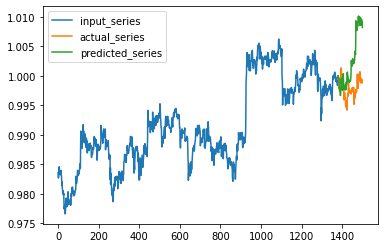

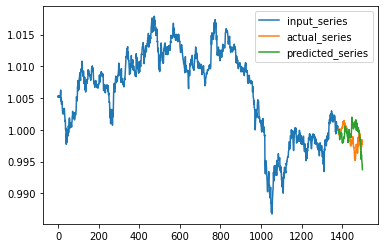

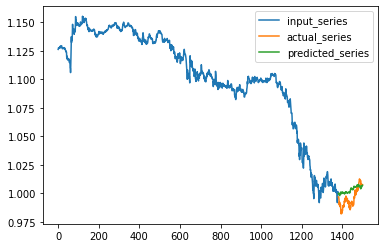

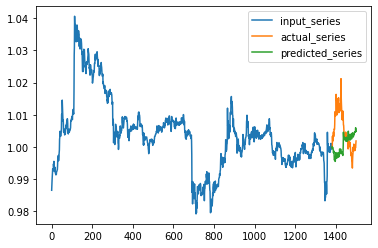

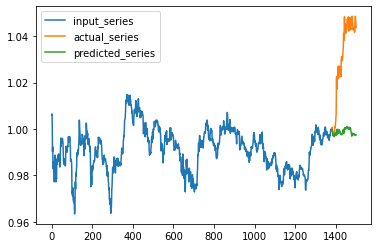

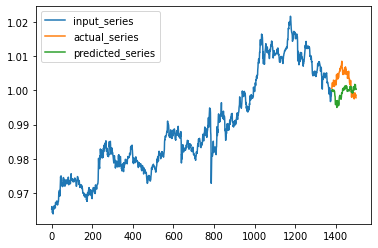

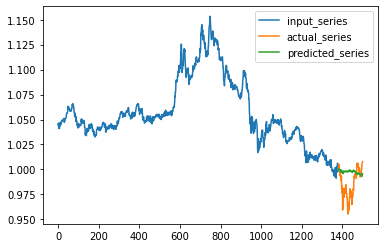

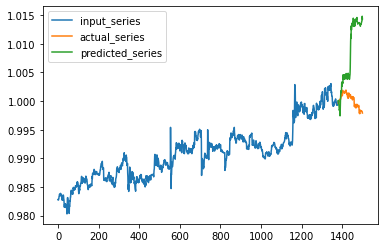

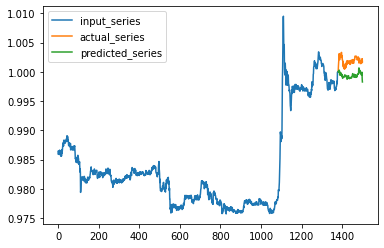

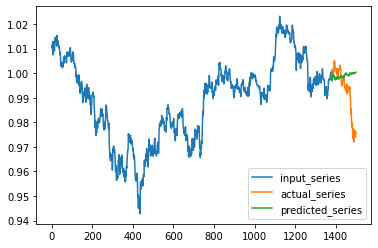

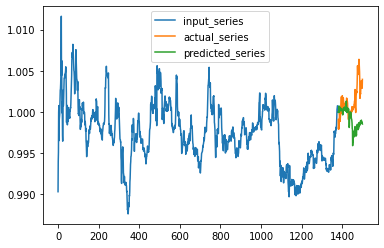

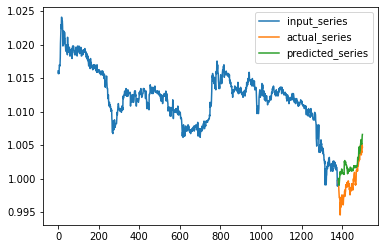

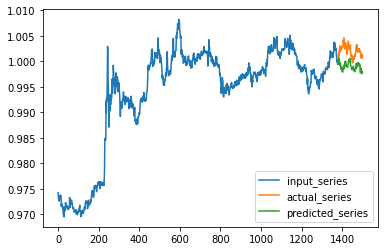

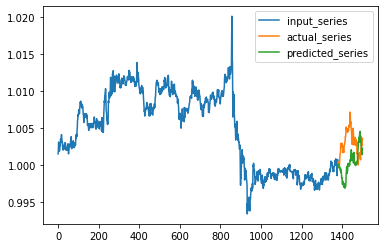

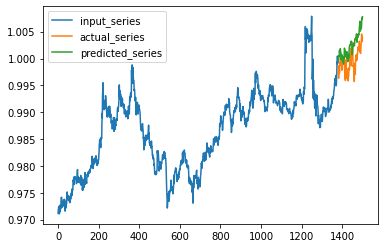

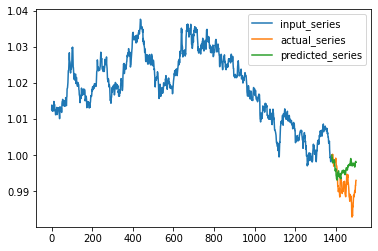

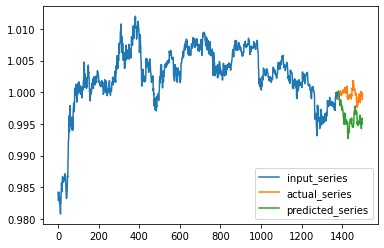

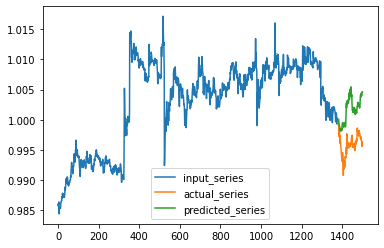

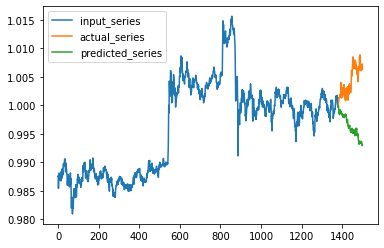

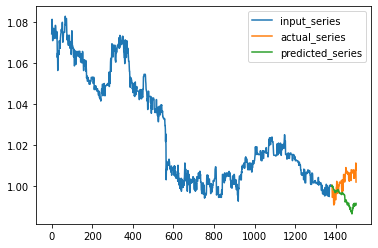

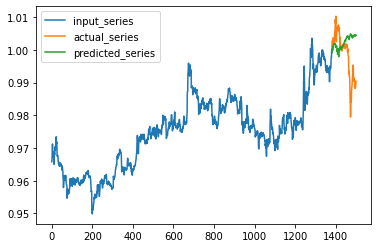

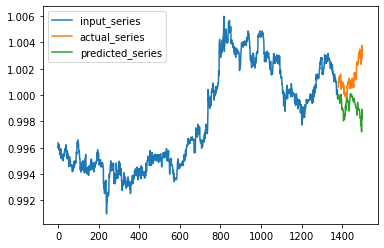

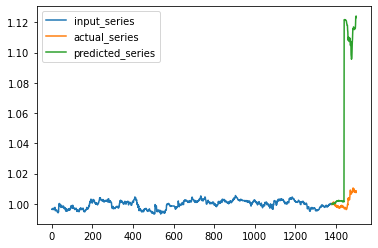

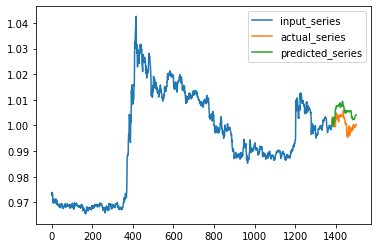

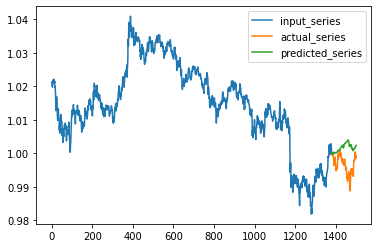

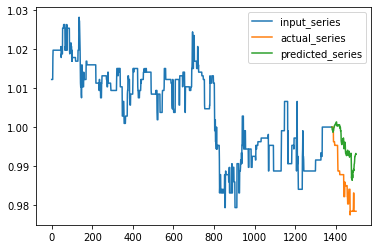

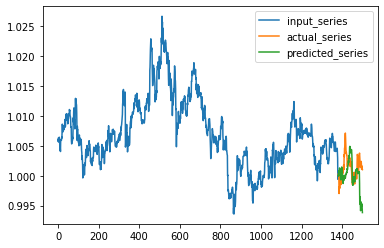

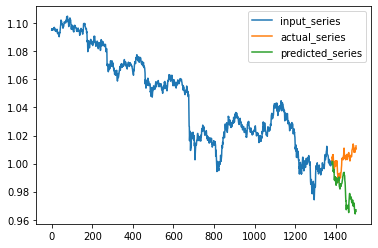

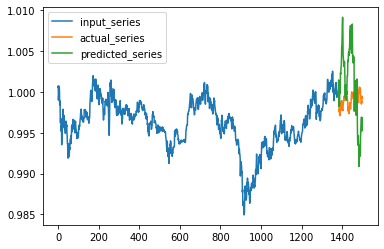

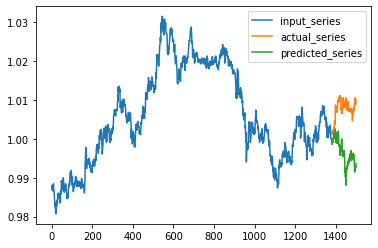

In [132]:
y_train_open = y_train[:,:,1]

for i in range(30): 
    plt.plot() 
    plot_series(x_train_open[i,:], y_train_open[i,:], pred_train[i,:])
    plt.show()


# Trying a different buy price methodology
Instead of deciding buy quantity solely on the proportion of points larger than buy price, we can also think about the number of positive returns.   

In [133]:
predicted = best_model.predict([X_test_price, X_test_volume]) 
predicted = predicted.reshape((-1,120)) 
predicted.shape


(535, 120)

In [134]:
x_test_open = x_test[:,:,1] 

## Adjust predicted prices to be connected with the buy price 
for i in tqdm(range(predicted.shape[0]), position = 0, leave = True):
    buy_price = x_test_open[i,-1] 
    if predicted[i,0] > buy_price:
        diff = predicted[i,0] - buy_price 
        predicted[i,:] -= diff 
    elif predicted[i,0] < buy_price:  
        diff = buy_price - predicted[i,0] 
        predicted[i,:] += diff


100%|██████████| 535/535 [00:00<00:00, 130789.34it/s]


In [135]:
## create submission dataframe version 2 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_open[i,-1] 
    cnt = 0 
    for j in range(120): 
        if j == 0: 
            ret = predicted[i,j] - buy_price 
        else: 
            ret = predicted[i,j]-predicted[i,j-1] 
        if ret > 0:  
            cnt += 1
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)
    
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times  
submission.to_csv('transformers_augmented_test2.csv',index=False)


100%|██████████| 535/535 [00:00<00:00, 3941.72it/s]


In [136]:
df1 = pd.read_csv('transformers_augmented_test.csv')
df2 = pd.read_csv('transformers_augmented_test2.csv')

In [137]:
df1

,sample_id,buy_quantity,sell_time
0,7661,0.858333,104
1,7662,1.000000,57
2,7663,0.958333,104
3,7664,0.341667,30
4,7665,0.850000,36
...,...,...,...
530,8191,0.008333,0
531,8192,0.041667,1
532,8193,0.741667,93
533,8194,0.175000,13


In [138]:
df2

,sample_id,buy_quantity,sell_time
0,7661,0.533333,104
1,7662,0.591667,57
2,7663,0.608333,104
3,7664,0.458333,30
4,7665,0.591667,36
...,...,...,...
530,8191,0.366667,0
531,8192,0.475000,1
532,8193,0.583333,93
533,8194,0.391667,13


In [139]:
submission.iloc[:,1] = (df1.iloc[:,1] + df2.iloc[:,1]) / 2.0 

submission

,sample_id,buy_quantity,sell_time
0,7661,0.695833,104
1,7662,0.795833,57
2,7663,0.783333,104
3,7664,0.400000,30
4,7665,0.720833,36
...,...,...,...
530,8191,0.187500,0
531,8192,0.258333,1
532,8193,0.662500,93
533,8194,0.283333,13


In [140]:
submission.to_csv('test_another_version.csv',index=False)